In [1]:
#load all packages

# base packages
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# tensorflow and keras
import tensorflow as tf
from keras import layers, models
from keras.utils import image_dataset_from_directory
from keras import metrics

# sklearn
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# self-build procedures
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass
from load_oasis_set import load_oasis_set
from load_oasis_set_win import load_oasis_set_win
from DataGenerator import DataGenerator

# model architectures
from cnn_backbone import base_model


### Load Train Data and oversample

In [2]:
# load dataset from drive
PATH = "/Users/josealbertodiazsalas/Documents/Alzheimer_s Dataset_30percentVal/train"
#PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset_30percentVal\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<---
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )
                                        
# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))


Found 3040 files belonging to 3 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-15 10:06:27.684960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 10:06:27.685074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Deconstuct Train Dataset and Prepare for Oversampling

In [3]:
# seperation of validation set
# !!! these sets are not shuffled !!!

train_big = train_ds
X1_train_big = []
y1_train_big = []
X2_train_big = []
y2_train_big = []
X3_train_big = []
y3_train_big = []


for img, label in train_ds.unbatch():
    if label.numpy()[0] == 1:
        X1_train_big.append(img.numpy())
        y1_train_big.append(label.numpy())

    if label.numpy()[1] == 1:
        X2_train_big.append(img.numpy())
        y2_train_big.append(label.numpy())

    if label.numpy()[2] == 1:
        X3_train_big.append(img.numpy())
        y3_train_big.append(label.numpy())

2022-06-15 10:06:27.744190: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Oversampling
Fill classes to match class 0 (Healthy)

In [4]:
# create dataset for class 1 -NO oversampling- (healthy)
X1_train_big = np.array(X1_train_big)
y1_train_big = np.array(y1_train_big)

In [5]:
# oversampling for class 2 (very mild)

randomPicksIdx = [np.random.choice(len(X2_train_big)) for i in range(len(X1_train_big) - len(X2_train_big))]

for i in randomPicksIdx:
    X2_train_big.append(X2_train_big[i])
    y2_train_big.append(y2_train_big[i])

X2_train_big = np.array(X2_train_big)
y2_train_big = np.array(y2_train_big)

In [6]:
# oversampling for class 3 (mild)
randomPicksIdx = [np.random.choice(len(X3_train_big)) for i in range(len(X1_train_big) - len(X3_train_big))]            # images are randomly picked

for i in randomPicksIdx:
    X3_train_big.append(X3_train_big[i])
    y3_train_big.append(y3_train_big[i])

X3_train_big = np.array(X3_train_big)
y3_train_big = np.array(y3_train_big)

### Construct full Dataset Tensor for Training

In [7]:
# combine all data sets
X_train_fullset = np.concatenate((X1_train_big,X2_train_big,X3_train_big), axis=0)
y_train_fullset = np.concatenate((y1_train_big,y2_train_big,y3_train_big), axis=0)

In [8]:
# shuffle the whole set
X_train_temp, y_train_temp = shuffle(X_train_fullset, y_train_fullset, random_state=10)

In [9]:
# finally create tensor dataset
data_generator = DataGenerator(X_train_temp, y_train_temp, batch_size = 32)

train_fullTensor = tf.data.Dataset.from_generator(
                                            data_generator,
                                            output_signature=(tf.TensorSpec(shape=(None, 208, 176, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, 3), dtype=tf.float32))
                                            )

### Load Validation Set

In [10]:
# load validation dataset from drive
# set for training
PATH = "/Users/josealbertodiazsalas/Documents/Alzheimer_s Dataset_30percentVal/validation"
#PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset_30percentVal\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_fullTensor = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

Found 2029 files belonging to 3 classes.


### Check Images for Integrity

In [1]:
# plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_fullTensor.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

NameError: name 'plt' is not defined

# Creating CNN Architecture
### First Creating Augmentation Module 

In [2]:
with tf.device("/cpu:0"):
    data_augmentation = keras.Sequential([
        layers.InputLayer(input_shape=(208, 176, 3)),
        layers.Lambda(lambda x: tf.image.resize(x, (208, 176))),
        layers.Lambda(lambda x: tf.image.random_contrast(x,0.6,1)),
        layers.Lambda(lambda x: tf.image.random_brightness(x,0.3)),             #<--- delta value depends on image range. if 0-1 delta should be between 0-1. if 0-255 delta should be between 0-255
        layers.RandomRotation(0.01),
        layers.RandomFlip(mode="horizontal"),    
        layers.RandomZoom(0.03),
        #layers.RandomBrightness((0.2), value_range=(0,255)),
        #layers.Resizing(208, 176),
        #layers.RandomContrast((0.2))
])

NameError: name 'tf' is not defined

### Check Images for proper Augmentation

In [3]:
with tf.device("/cpu:0"):
    plt.figure(figsize=(10, 10))
    for images, labels in train_fullTensor.take(1):
        for i in range(3):
            ax = plt.subplot(1, 3, i + 1)
            img = data_augmentation(images/255)             # divided by 255 (normalization) since augmentation depends on normalization which is 
            plt.imshow(img[i].numpy(), cmap="gray")         # a specific layer in the CNN and not part of augmentation
            plt.title([labels[i].numpy()][0])
            plt.axis("off")

NameError: name 'tf' is not defined

### Building the complete CNN
#### Construct DENSENET201 Backbone

In [4]:
# Defining both base and final model architecture
b_model = base_model(MODEL='DenseNet201', freeze_layers=True)
b_model.summary()

NameError: name 'base_model' is not defined

### Combine Backbone with Augmentation and Dense Layers

In [15]:
# Definition conv and classification layers
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(208, 176, 3)))
model.add(layers.Rescaling(1.0/255))
model.add(data_augmentation)
model.add(b_model)
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(2048,kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024,kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))

# Print only Conv and Pooling layer from model architecture
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 sequential (Sequential)     (None, 208, 176, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 6, 5, 1920)        0         
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 batch_normalization (BatchN  (None, 57600)            230400    
 ormalization)                                                   
                                                      

### Defining the Optimizer

In [18]:
# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=10000,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

### Compile the CNN Architecture

In [17]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall()])

### Train the Model
You can chose the save the model iterativly at every checkpoint by including the lines

In [18]:
# Saving model parameters and weights per epoch
#checkpoint_filepath = 'F:\\MRI_class\\data\\Alzheimer_s Dataset_20percentVal\\SimpleCNN_lr10-4\\checkpoint_model.epoch{epoch:02d}-recall{val_recall:.2f}.hdf5'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
#save_best_only=True)

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_history = model.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=30, 
                        shuffle=True
                        #callbacks=[model_checkpoint_callback]
                        )

Epoch 1/30


2022-06-14 16:03:10.300145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    144/Unknown - 134s 880ms/step - loss: 1.2862 - precision: 0.4888 - recall: 0.4122

2022-06-14 16:05:21.347555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 175s 1s/step - loss: 1.2862 - precision: 0.4888 - recall: 0.4122 - val_loss: 0.7792 - val_precision: 0.7216 - val_recall: 0.4510
Epoch 2/30
144/144 [==============================] - 174s 1s/step - loss: 0.6180 - precision: 0.7769 - recall: 0.6845 - val_loss: 0.7400 - val_precision: 0.7448 - val_recall: 0.5249
Epoch 3/30
144/144 [==============================] - 176s 1s/step - loss: 0.3454 - precision: 0.8949 - recall: 0.8465 - val_loss: 0.7026 - val_precision: 0.7383 - val_recall: 0.5840
Epoch 4/30
144/144 [==============================] - 173s 1s/step - loss: 0.2202 - precision: 0.9357 - recall: 0.9129 - val_loss: 0.6826 - val_precision: 0.7417 - val_recall: 0.6269
Epoch 5/30
144/144 [==============================] - 185s 1s/step - loss: 0.1539 - precision: 0.9561 - recall: 0.9403 - val_loss: 0.6760 - val_precision: 0.7359 - val_recall: 0.6427
Epoch 6/30
144/144 [==============================] - 184s 1s/step - loss: 0.1163 - precision: 0

### Visualize Training Results

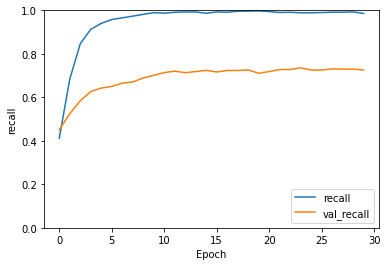

In [19]:
plt.plot(model_history.history['recall'], label='recall')
plt.plot(model_history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

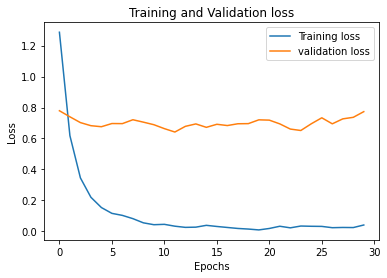

In [22]:

plt.plot(model_history.history['loss'], label='Training loss')
plt.plot(model_history.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save the Model

In [24]:
model.save('/Users/josealbertodiazsalas/Documents/densenet201')
#model.save('/Users/josealbertodiazsalas/Documents/densenet201.h5')

INFO:tensorflow:Assets written to: /Users/josealbertodiazsalas/Documents/densenet201/assets


INFO:tensorflow:Assets written to: /Users/josealbertodiazsalas/Documents/densenet201/assets


-----
### Model 2

In [17]:
# Definition conv and classification layers
model_2 = models.Sequential()
model_2.add(layers.InputLayer(input_shape=(208, 176, 3)))
model_2.add(layers.Rescaling(1.0/255))
model_2.add(data_augmentation)
model_2.add(b_model)
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Flatten())
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dense(1024,kernel_initializer='he_uniform'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(512,kernel_initializer='he_uniform'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(3,activation='softmax'))

# Print only Conv and Pooling layer from model architecture
model_2.build()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 sequential (Sequential)     (None, 208, 176, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 6, 5, 1920)        0         
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 batch_normalization (BatchN  (None, 57600)            230400    
 ormalization)                                                   
                                                        

In [18]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model_2.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall()])

In [19]:
# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_2_history = model_2.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=30, 
                        shuffle=True
                        #callbacks=[model_checkpoint_callback]
                        )

Epoch 1/30


2022-06-14 17:52:14.155063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    144/Unknown - 116s 747ms/step - loss: 1.2115 - precision: 0.5078 - recall: 0.4193

2022-06-14 17:54:06.223044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 157s 1s/step - loss: 1.2115 - precision: 0.5078 - recall: 0.4193 - val_loss: 0.7899 - val_precision: 0.6830 - val_recall: 0.4810
Epoch 2/30
144/144 [==============================] - 173s 1s/step - loss: 0.5844 - precision: 0.8022 - recall: 0.7036 - val_loss: 0.7607 - val_precision: 0.7210 - val_recall: 0.5145
Epoch 3/30
144/144 [==============================] - 200s 1s/step - loss: 0.3238 - precision: 0.9079 - recall: 0.8630 - val_loss: 0.7291 - val_precision: 0.7276 - val_recall: 0.5712
Epoch 4/30
144/144 [==============================] - 184s 1s/step - loss: 0.1921 - precision: 0.9471 - recall: 0.9292 - val_loss: 0.6925 - val_precision: 0.7363 - val_recall: 0.6111
Epoch 5/30
144/144 [==============================] - 172s 1s/step - loss: 0.1458 - precision: 0.9600 - recall: 0.9483 - val_loss: 0.6699 - val_precision: 0.7472 - val_recall: 0.6540
Epoch 6/30
144/144 [==============================] - 169s 1s/step - loss: 0.1203 - precision: 0

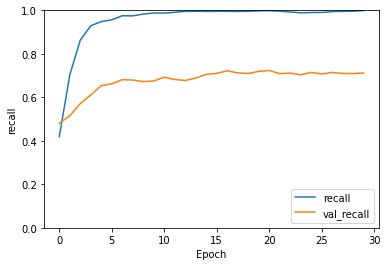

In [20]:
plt.plot(model_2_history.history['recall'], label='recall')
plt.plot(model_2_history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

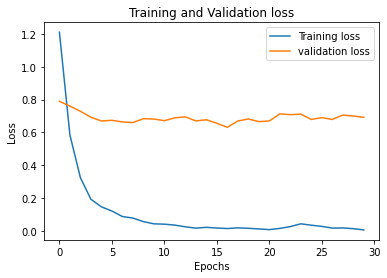

In [21]:
plt.plot(model_2_history.history['loss'], label='Training loss')
plt.plot(model_2_history.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

______
### Model 3

In [22]:
# Definition conv and classification layers
model_3 = models.Sequential()
model_3.add(layers.InputLayer(input_shape=(208, 176, 3)))
model_3.add(layers.Rescaling(1.0/255))
model_3.add(data_augmentation)
model_3.add(b_model)
model_3.add(layers.Flatten())
model_3.add(layers.Dense(512,kernel_initializer='he_uniform'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Activation('relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(256,kernel_initializer='he_uniform'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Activation('relu'))
model_3.add(layers.Dense(128,kernel_initializer='he_uniform'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Activation('relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(3,activation='softmax'))

# Print only Conv and Pooling layer from model architecture
model_3.build()
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 sequential (Sequential)     (None, 208, 176, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 512)               29491712  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

In [23]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model_3.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall()])

In [24]:
# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_3_history = model_3.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=30, 
                        shuffle=True
                        #callbacks=[model_checkpoint_callback]
                        )

Epoch 1/30


2022-06-14 19:18:14.694464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    144/Unknown - 109s 700ms/step - loss: 1.0054 - precision: 0.5894 - recall: 0.4869

2022-06-14 19:19:59.481477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 151s 988ms/step - loss: 1.0054 - precision: 0.5894 - recall: 0.4869 - val_loss: 0.8493 - val_precision: 0.6385 - val_recall: 0.5614
Epoch 2/30
144/144 [==============================] - 135s 942ms/step - loss: 0.4420 - precision: 0.8832 - recall: 0.7980 - val_loss: 0.6593 - val_precision: 0.7491 - val_recall: 0.6269
Epoch 3/30
144/144 [==============================] - 136s 942ms/step - loss: 0.2665 - precision: 0.9543 - recall: 0.9125 - val_loss: 0.6719 - val_precision: 0.7474 - val_recall: 0.6373
Epoch 4/30
144/144 [==============================] - 136s 943ms/step - loss: 0.1703 - precision: 0.9828 - recall: 0.9655 - val_loss: 0.5989 - val_precision: 0.7841 - val_recall: 0.6910
Epoch 5/30
144/144 [==============================] - 135s 937ms/step - loss: 0.1124 - precision: 0.9945 - recall: 0.9874 - val_loss: 0.5725 - val_precision: 0.7991 - val_recall: 0.7077
Epoch 6/30
144/144 [==============================] - 135s 936ms/step - loss: 0.0

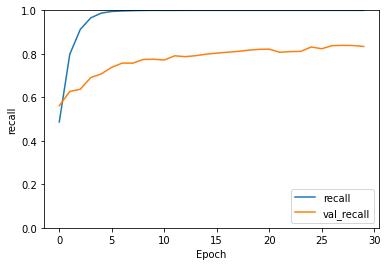

In [25]:
plt.plot(model_3_history.history['recall'], label='recall')
plt.plot(model_3_history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

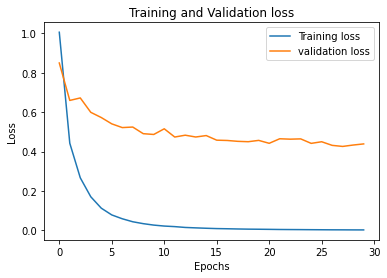

In [26]:
plt.plot(model_3_history.history['loss'], label='Training loss')
plt.plot(model_3_history.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

______
### Model 4

In [15]:
# Defining both base and final model architecture
b_model = base_model(MODEL='DenseNet201', freeze_layers=True)

In [16]:
# Definition conv and classification layers
model_4 = models.Sequential()
model_4.add(layers.InputLayer(input_shape=(208, 176, 3)))
model_4.add(layers.Rescaling(1.0/255))
model_4.add(data_augmentation)
model_4.add(b_model)
model_4.add(layers.Flatten())
model_4.add(layers.Dense(512,kernel_initializer='he_uniform'))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Activation('relu'))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(256,kernel_initializer='he_uniform'))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Activation('relu'))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(3,activation='softmax'))

# Print only Conv and Pooling layer from model architecture
model_4.build()
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 sequential (Sequential)     (None, 208, 176, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 512)               29491712  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                      

In [19]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model_4.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall()])

In [20]:
# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_4_history = model_4.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=50, 
                        shuffle=True
                        #callbacks=[model_checkpoint_callback]
                        )

Epoch 1/50


2022-06-15 10:08:16.226338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    144/Unknown - 150s 981ms/step - loss: 0.7677 - precision: 0.7265 - recall: 0.6269

2022-06-15 10:10:44.032071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 192s 1s/step - loss: 0.7677 - precision: 0.7265 - recall: 0.6269 - val_loss: 0.8655 - val_precision: 0.6670 - val_recall: 0.6309
Epoch 2/50
144/144 [==============================] - 213s 1s/step - loss: 0.2899 - precision: 0.9289 - recall: 0.8908 - val_loss: 0.5877 - val_precision: 0.7598 - val_recall: 0.7279
Epoch 3/50
144/144 [==============================] - 193s 1s/step - loss: 0.1371 - precision: 0.9778 - recall: 0.9661 - val_loss: 0.4916 - val_precision: 0.8225 - val_recall: 0.7698
Epoch 4/50
144/144 [==============================] - 163s 1s/step - loss: 0.0799 - precision: 0.9898 - recall: 0.9863 - val_loss: 0.4876 - val_precision: 0.8139 - val_recall: 0.7738
Epoch 5/50
144/144 [==============================] - 166s 1s/step - loss: 0.0469 - precision: 0.9974 - recall: 0.9961 - val_loss: 0.3977 - val_precision: 0.8601 - val_recall: 0.8275
Epoch 6/50
144/144 [==============================] - 155s 1s/step - loss: 0.0356 - precision: 0

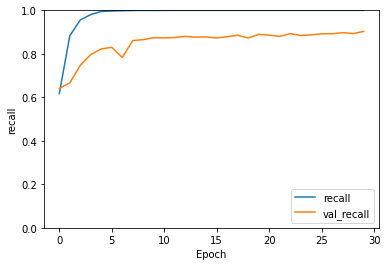

In [79]:
plt.plot(model_4_history.history['recall'], label='recall')
plt.plot(model_4_history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

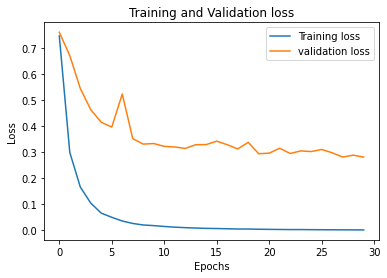

In [80]:
plt.plot(model_4_history.history['loss'], label='Training loss')
plt.plot(model_4_history.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
#model_4.save('/Users/josealbertodiazsalas/Documents/densenet201')
model_4.save('/Users/josealbertodiazsalas/Documents/densenet201.h5')

INFO:tensorflow:Assets written to: /Users/josealbertodiazsalas/Documents/densenet201/assets


INFO:tensorflow:Assets written to: /Users/josealbertodiazsalas/Documents/densenet201/assets


------
### MOdel 5

In [39]:
# Defining both base and final model architecture
b_model = base_model(MODEL='DenseNet201', freeze_layers=False)

In [40]:
# Definition conv and classification layers
model_5 = models.Sequential()
model_5.add(layers.InputLayer(input_shape=(208, 176, 3)))
model_5.add(layers.Rescaling(1.0/255))
model_5.add(data_augmentation)
model_5.add(b_model)
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Flatten())
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dense(512,kernel_initializer='he_uniform'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Activation('relu'))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(256,kernel_initializer='he_uniform'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Activation('relu'))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(3,activation='softmax'))

# Print only Conv and Pooling layer from model architecture
model_5.build()
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 sequential (Sequential)     (None, 208, 176, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 6, 5, 1920)        0         
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 batch_normalization (BatchN  (None, 57600)            230400    
 ormalization)                                                   
                                                        

In [41]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model_5.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall()])

In [42]:

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_5_history = model_5.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=30, 
                        shuffle=True
                        #callbacks=[model_checkpoint_callback]
                        )

Epoch 1/30


2022-06-14 23:21:19.058352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    144/Unknown - 780s 5s/step - loss: 1.0502 - precision: 0.5693 - recall: 0.4671

2022-06-14 23:34:10.938128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 825s 5s/step - loss: 1.0502 - precision: 0.5693 - recall: 0.4671 - val_loss: 1.0383 - val_precision: 0.5774 - val_recall: 0.5185
Epoch 2/30
144/144 [==============================] - 717s 5s/step - loss: 0.5429 - precision: 0.8018 - recall: 0.7275 - val_loss: 0.8651 - val_precision: 0.6443 - val_recall: 0.5525
Epoch 3/30
144/144 [==============================] - 674s 5s/step - loss: 0.2928 - precision: 0.9041 - recall: 0.8762 - val_loss: 0.5961 - val_precision: 0.7931 - val_recall: 0.6875
Epoch 4/30
144/144 [==============================] - 743s 5s/step - loss: 0.1490 - precision: 0.9577 - recall: 0.9481 - val_loss: 0.5775 - val_precision: 0.7824 - val_recall: 0.7018
Epoch 5/30
144/144 [==============================] - 695s 5s/step - loss: 0.0881 - precision: 0.9791 - recall: 0.9750 - val_loss: 0.3884 - val_precision: 0.8678 - val_recall: 0.8280
Epoch 6/30
144/144 [==============================] - 748s 5s/step - loss: 0.0559 - precision: 0

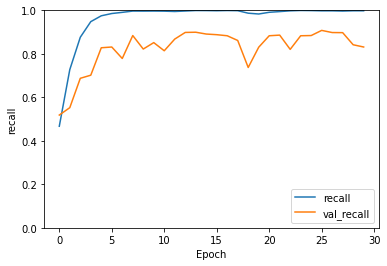

In [43]:
plt.plot(model_5_history.history['recall'], label='recall')
plt.plot(model_5_history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

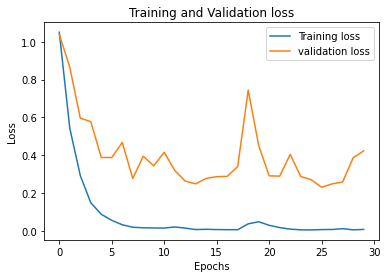

In [44]:
plt.plot(model_5_history.history['loss'], label='Training loss')
plt.plot(model_5_history.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

------
### Model 6

In [63]:
# Defining both base and final model architecture
b_model = base_model(MODEL='DenseNet201', freeze_layers=False)

In [72]:
# Definition conv and classification layers
model_6 = models.Sequential()
model_6.add(layers.InputLayer(input_shape=(208, 176, 3)))
model_6.add(layers.Rescaling(1.0/255))
model_6.add(data_augmentation)
model_6.add(b_model)
model_6.add(layers.Flatten())
model_6.add(layers.Dense(256,kernel_initializer='he_uniform'))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Activation('relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(256,kernel_initializer='he_uniform'))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Activation('relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(3,activation='softmax'))

# Print only Conv and Pooling layer from model architecture
model_6.build()
model_6.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 208, 176, 3)       0         
                                                                 
 sequential (Sequential)     (None, 208, 176, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 flatten_17 (Flatten)        (None, 57600)             0         
                                                                 
 dense_56 (Dense)            (None, 256)               14745856  
                                                                 
 batch_normalization_38 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                     

In [73]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model_6.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall()])

In [ ]:

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_6_history = model_6.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=30, 
                        shuffle=True
                        #callbacks=[model_checkpoint_callback]
                        )

In [ ]:
plt.plot(model_history.history['val_recall'], label = 'model_1')
plt.plot(model_2_history.history['val_recall'], label = 'model_2')
plt.plot(model_3_history.history['val_recall'], label = 'model_3')
plt.plot(model_4_history.history['val_recall'], label = 'model_4')
plt.plot(model_5_history.history['val_recall'], label = 'model_5')
plt.title('Validation recall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Load a Testset

In [ ]:
oasis_img_temp, oasis_label_temp = load_oasis_set_win()



Image Array Shape: (231, 208, 176, 3) 

Image Count: 231 

labels: [0. 1. 2. 3.] 

Class Counts:
      ID
CDR     
0.0  131
1.0   70
2.0   28
3.0    2


### Get only classes 0, 1 and 2 of the Testset

In [ ]:
oasis_images = []
oasis_labels = []
for image,label in zip(oasis_img_temp,oasis_label_temp):
    if int(label) == 3:
        continue
    if int(label) == 0:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([1,0,0])
    if int(label) == 1:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([0,1,0])
    if int(label) == 2:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([0,0,1])

oasis_images = np.array(oasis_images)
oasis_labels = np.array(oasis_labels)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


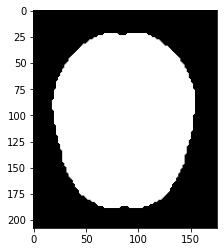

In [ ]:
plt.imshow(oasis_images[0].astype("uint8"))

### Perform a Prediction on the Testset and Visualize the Results

In [ ]:
oasis_pred = model.predict(oasis_images, batch_size=1)

229/229 [==============================] - 1s 4ms/step


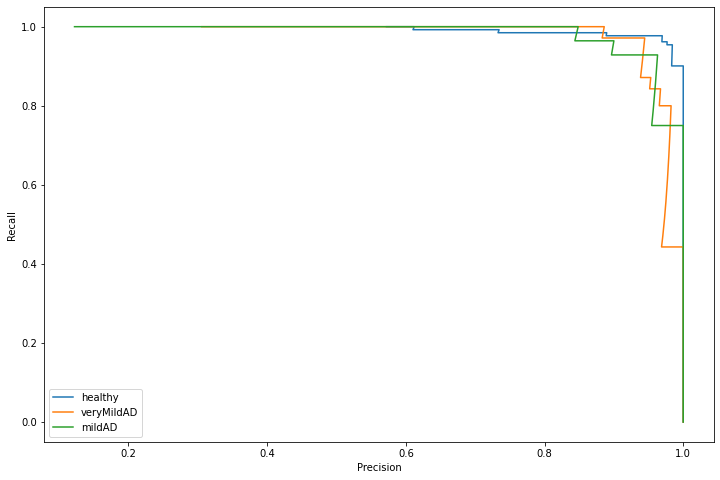

-----Recalls-----
healthy Recall: 0.9770992366412213
veryMildAD Recall: 0.9285714285714286
mildAD Recall: 0.8928571428571429
-------#####-------


-----Precisions-----
healthy Precision: 0.9552238805970149
veryMildAD Precision: 0.9420289855072463
mildAD Precision: 0.9615384615384616
-------#####-------


-----Macro Recall and Precisions-----
Macro recall: 0.9328426026899309
Macro recall: 0.9529304425475743
-------#####-------


In [ ]:
precision_recall_multiclass(oasis_pred,oasis_labels,["healthy","veryMildAD","mildAD"])